# Impact of $c_s^2$ on observables

Usual dark energy models assume an effective sound speed of $c_s^2 = 1$. What is the impact of another choice, *e.g.* $c_s^2 = 0$?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["legend.framealpha"] = 0.0

In [2]:
H0 = 67
h = H0/100
omegab = 0.049
omegam = 0.319
omegac = omegam - omegab
As = 2.1e-9
ns = 0.96
tau = 0.07
ombh2 = omegab*h*h
omch2 = omegac*h*h
# DESI DR2 BAO + CMB + Pantheon+ mean
# w0 = -0.838
# wa = -0.62
w0 = -0.8
wa = 0
ks = np.logspace(-3, 0.1, 200)
scale_factors = np.logspace(-4, 0, 200)
redshifts = 1/scale_factors - 1

In [ ]:
cases = [
    {"name": "quint", "label": "$c_s^2 = 1$",         "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1,                      "cs2_1": 0},
    {"name": "clust1e-1", "label": "$c_s^2 = 0.1$",         "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-1,                   "cs2_1": 0},
    {"name": "clust1e-2", "label": "$c_s^2 = 0.01$",         "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-2,                   "cs2_1": 0},
    {"name": "clust1e-3", "label": "$c_s^2 = 0.001$",         "cs2_type": camb.dark_energy.Cs2_Constant, "cs2_0": 1e-3,                   "cs2_1": 0},
    # {"name": "0to1",  "label": "$c_s^2$ from 0 to 1", "cs2_type": camb.dark_energy.Cs2_PropToW,  "cs2_0": 1 - (-1/wa - 0.001)*w0, "cs2_1": -1/wa - 0.001},
    # {"name": "1to0",  "label": "$c_s^2$ from 1 to 0", "cs2_type": camb.dark_energy.Cs2_PropToW,  "cs2_0": -(1/wa + 0.001)*w0,     "cs2_1": 1/wa + 0.001},
]

def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, WantTransfer=True, w0=w0, wa=wa, dark_energy_model="ppf",
        cs2_type=case["cs2_type"], cs2_0=case["cs2_0"], cs2_1=case["cs2_1"]
    )
    cosmo.set_for_lmax(2000, lens_potential_accuracy=1)
    cosmo.set_matter_power(redshifts=redshifts, kmax=20, silent=True, nonlinear=True)
    results = camb.get_results(cosmo)
    P_lin = results.get_matter_power_interpolator(nonlinear=None).P(0, ks)
    fsigma8 = results.get_fsigma8()
    cl_tt = results.get_lensed_scalar_cls(CMB_unit='muK')[:,0]
    cl_ee = results.get_lensed_scalar_cls(CMB_unit='muK')[:,1]
    cl_te = results.get_lensed_scalar_cls(CMB_unit='muK')[:,3]
    cl_pp = results.get_lens_potential_cls(lmax=2000)[:,0]
    ev    = results.get_redshift_evolution(ks, redshifts, ['delta_cdm', 'delta_tot', 'delta_tot_de']) # NOTE: tot here does not include DE, tot_de does
    tdata = results.get_matter_transfer_data()
    rhos  = results.get_background_densities(a=1/(1 + redshifts))
    rho_de    = rhos["de"]
    rho_no_de = rhos["cdm"] + rhos["baryon"] + rhos["neutrino"]
    # rho_no_de = rho_tot - rho_de
    delta_cdm   = ev[:, :, 0]
    delta_no_de = ev[:, :, 1]
    delta_tot   = ev[:, :, 2]
    delta_de = (rho_no_de*delta_tot - rho_no_de*delta_no_de)/rho_de
    return {"P_lin": P_lin, "fsigma8": fsigma8, "cl_tt": cl_tt, "cl_ee": cl_ee, "cl_te": cl_te, "cl_pp": cl_pp, "delta_cdm": delta_cdm, "delta_de": delta_de, "tdata": tdata, "rhos": rhos}

data = {}
for case in cases:
    data[case["name"]] = get_observables(case)

<>:7: SyntaxWarning: invalid escape sequence '\;'
<>:7: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_44993/449188040.py:7: SyntaxWarning: invalid escape sequence '\;'
  plt.xlabel("$k \; (h/\mathrm{Mpc})$", fontsize=15)


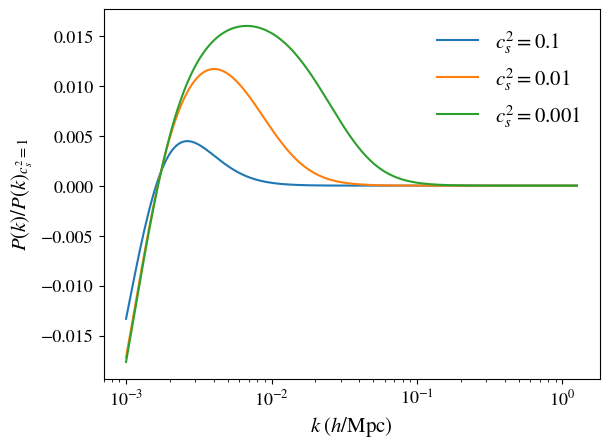

In [4]:
# Plot P(k)
for case in cases:
    if case["name"] == "quint": continue
    plt.semilogx(ks, data[case["name"]]["P_lin"]/data["quint"]["P_lin"] - 1, label=case["label"])

plt.tick_params(labelsize=13)
plt.xlabel("$k \; (h/\mathrm{Mpc})$", fontsize=15)
plt.ylabel("$P(k)/P(k)_{c_s^2 = 1}$", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("plots/cs2_impact_pk.pdf")

Text(0.5, 1.0, 'Impact of the sound speed on $f\\sigma_8$')

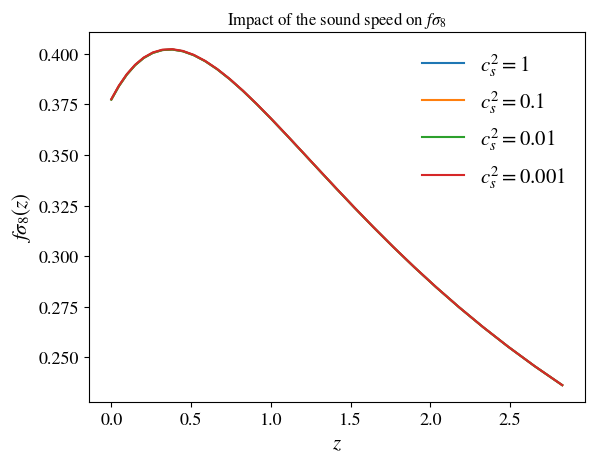

In [5]:
# Plot P(k)
for case in cases:
    # if case["name"] == "quint": continue
    plt.plot(redshifts[redshifts < 3], data[case["name"]]["fsigma8"][redshifts < 3], label=case["label"])

plt.tick_params(labelsize=13)
plt.xlabel("$z$", fontsize=15)
plt.ylabel("$f\\sigma_8(z)$", fontsize=15)
plt.legend(fontsize=15)
# plt.savefig("plots/cs2_impact_pk.pdf")


plt.title("Impact of the sound speed on $f\\sigma_8$")

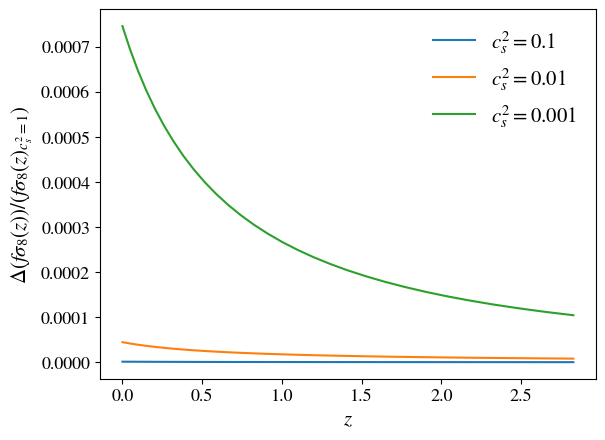

In [6]:
# Plot P(k)
for case in cases:
    if case["name"] == "quint": continue
    plt.plot(redshifts[redshifts < 3], data[case["name"]]["fsigma8"][redshifts < 3]/data["quint"]["fsigma8"][redshifts < 3] - 1, label=case["label"])

plt.tick_params(labelsize=13)
plt.xlabel("$z$", fontsize=15)
plt.ylabel(r"$\Delta(f\sigma_8(z))/(f\sigma_8(z)_{c_s^2=1})$", fontsize=15)
plt.legend(fontsize=15)
# plt.savefig("plots/cs2_impact_pk.pdf")

/tmp/ipykernel_44993/2959947901.py:5: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(ells, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])


Text(0.5, 1.0, 'Impact of $c_s^2$ on CMB lensing')

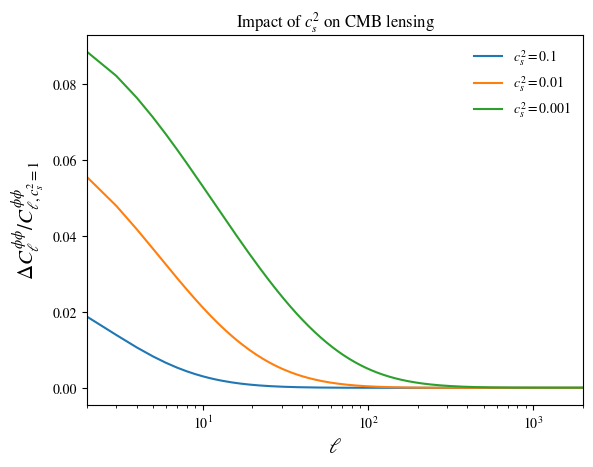

In [7]:
# Plot P(k)
ells = np.arange(2001)
for case in cases:
    if case["name"] == "quint": continue
    plt.semilogx(ells, data[case["name"]]["cl_pp"]/data["quint"]["cl_pp"] - 1, label=case["label"])

plt.xlim([2, 2000])
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$\Delta C_\ell^{\phi\phi}/C_{\ell, c_s^2=1}^{\phi\phi}$", fontsize=15)
plt.legend()
plt.title("Impact of $c_s^2$ on CMB lensing")

/tmp/ipykernel_44993/1161832246.py:5: RuntimeWarning: invalid value encountered in divide
  plt.semilogx(ells, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])


Text(0.5, 1.0, 'Impact of $c_s^2$ on CMB TT')

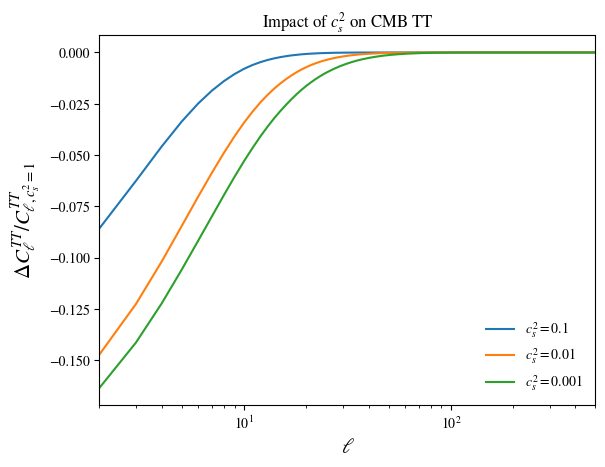

In [8]:
# Plot P(k)
ells = np.arange(2051)
for case in cases:
    if case["name"] == "quint": continue
    plt.semilogx(ells, data[case["name"]]["cl_tt"]/data["quint"]["cl_tt"] - 1, label=case["label"])

plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$\Delta C_\ell^{TT}/C_{\ell, c_s^2=1}^{TT}$", fontsize=15)
plt.xlim([2, 500])
plt.legend()
plt.title("Impact of $c_s^2$ on CMB TT")

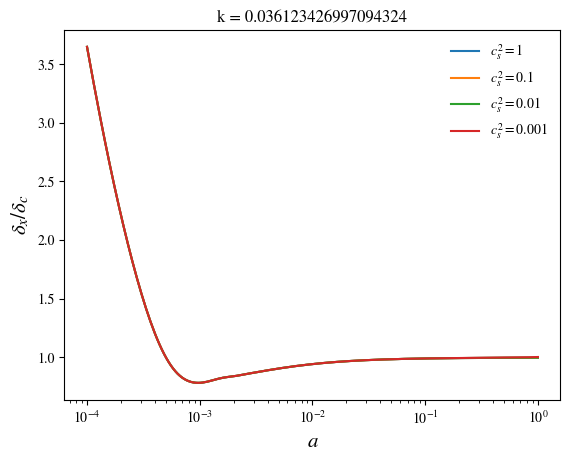

In [19]:
k_index = 100
for case in cases:
    plt.semilogx(scale_factors, data[case["name"]]["delta_de"][k_index]/data[case["name"]]["delta_cdm"][k_index],  label=case["label"])
plt.title(f"k = {ks[k_index]}")
plt.xlabel("$a$", fontsize=15)
plt.ylabel(r"$\delta_x/\delta_c$", fontsize=15)
plt.legend()

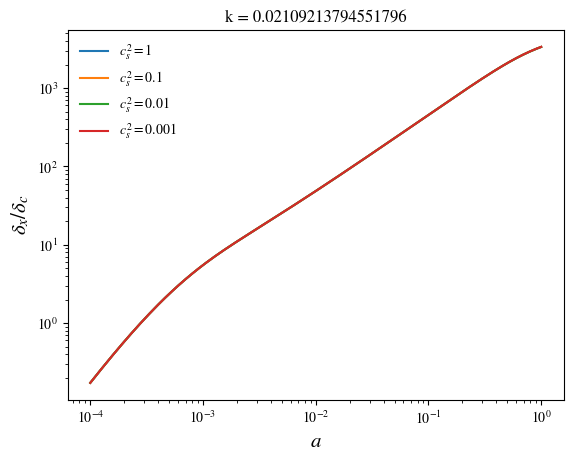

In [13]:
k_index = 85
for case in cases:
    plt.loglog(scale_factors, data[case["name"]]["delta_cdm"][k_index],  label=case["label"])
plt.title(f"k = {ks[k_index]}")
plt.xlabel("$a$", fontsize=15)
plt.ylabel(r"$\delta_x/\delta_c$", fontsize=15)
plt.legend()

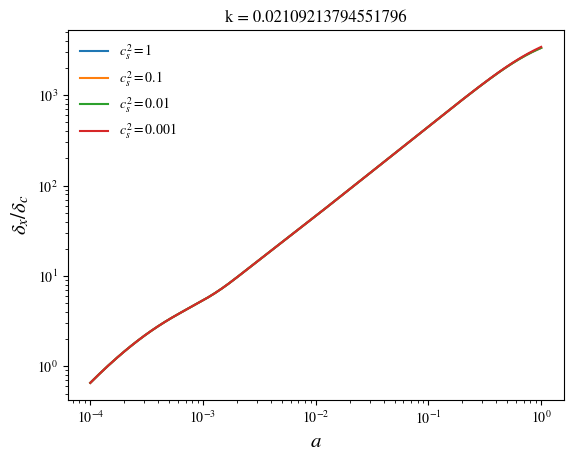

In [ ]:
k_index = 85
for case in cases:
    plt.loglog(scale_factors, data[case["name"]]["tdata"][k_index],  label=case["label"])
plt.title(f"k = {ks[k_index]}")
plt.xlabel("$a$", fontsize=15)
plt.ylabel(r"$\delta_x/\delta_c$", fontsize=15)
plt.legend()

In [60]:
tdata = data["quint"]["tdata"]
rhos = data["quint"]["rhos"]
rho_m = rhos["cdm"] + rhos["baryon"] + rhos["nu"]
tdata_k = tdata.q/h
tdata_delta_cdm = tdata.transfer_data[1] # Shape is (nk, nz)
tdata_delta_phot = tdata.transfer_data[3] # Shape is (nk, nz)
tdata_delta_no_de = tdata.transfer_data[6] # Shape is (nk, nz)
tdata_delta_tot = tdata.transfer_data[8] # Shape is (nk, nz)
print(len(tdata_k))
tdata_delta_de = (rho_m*tdata_delta_tot - rho_m*tdata_delta_no_de)/rhos["de"]

221


ValueError: operands could not be broadcast together with shapes (200,) (221,249) 

ValueError: x and y must have same first dimension, but have shapes (200,) and (249,)

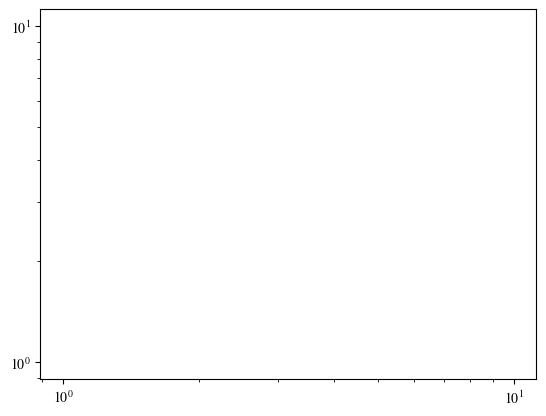

In [ ]:
for i, z in enumerate(redshifts):
    k_index = 0
    delta_cdm = tdata.transfer_data[1, k_index, :]*tdata_k[k_index]**2
    plt.loglog(redshifts, delta_cdm)
    break
    # if i == 5: break

200

In [56]:
len(tdata.transfer_data[0, 0])

249